In [1]:

import kagglehub
from numpy import dtype

dataset_path = kagglehub.dataset_download('sukhdayaldhanday/dream-11-fantasy-points-data-of-ipl-all-seasons')
# dataset_path = '/home/dev/.cache/kagglehub/datasets/sukhdayaldhanday/dream-11-fantasy-points-data-of-ipl-all-seasons/versions/1'

print('Data source import complete.')
dataset_path

/home/dev/PycharmProjects/Dream11/.venv1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


'/home/dev/.cache/kagglehub/datasets/sukhdayaldhanday/dream-11-fantasy-points-data-of-ipl-all-seasons/versions/1'

In [2]:


import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler



In [180]:

class FantasyData(Dataset):
    def __init__(self,device,df):
        x,y= self.preprocess_batting(df)
        self.x = x.to(device)
        self.y = y.to(device)
        self.device = device
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def transform_batting_data(self , df):

        self.batter_data = {}
        # Ensure the data is sorted by season and match_id
        df = df[df['season'] > 2015]
        # df = df.sort_values(["season", "match_id"]).reset_index(drop=True)

        # Get all unique venues for one-hot encoding later
        # unique_venues = sorted(df["venue"].unique())

        # List to store each row's transformed dictionary
        transformed_rows = []

        # Process each batter separately
        for batter, group in df.groupby("fullName"):
            prev = -1
            # Sort the batter's matches in chronological order
            group = group.sort_values(["season", "match_id"]).reset_index(drop=True)
            # List to keep track of previous match scores for this batter
            previous_scores = []

            # Iterate over the batter's matches
            for i, row in group.iterrows():
                current_season = row["season"]

                # Previous match score: last score in the list, if available
                prev_match_score = previous_scores[-1] if previous_scores else None

                # Previous 5 matches average points: average of last 5 scores
                last_five = previous_scores[-5:] if previous_scores else []
                prev_5_avg = sum(last_five) / len(last_five) if last_five else None

                # Previous season average points: consider all matches of this batter with season < current_season
                prev_season_scores = group[group["season"] < current_season]["Batting_FP"].tolist()
                prev_season_avg = sum(prev_season_scores) / len(prev_season_scores) if prev_season_scores else None

                # Number of matches played so far (i.e. count of previous scores)
                num_matches = len(previous_scores)

                # One hot encode the venue for this match
                # venue_encoding = {v: 1 if row["venue"] == v else 0 for v in unique_venues}

                # Create the dictionary for the current row
                row_dict = {
                    "Batter name": row["fullName"],
                    "prev": prev_match_score,
                    "prev5": prev_5_avg,
                    "prevSSN": prev_season_avg,
                    "num matches": num_matches,
                    "venue": row["venue"],
                    "season": current_season,
                    "Batting_FP" : row["Batting_FP"],
                }
                # row_dict.extend(venue_encoding)

                transformed_rows.append(row_dict)
                prev = row_dict
                # Update the list of previous scores with the current match's score
                previous_scores.append(row["Batting_FP"])
            self.batter_data[batter] = prev

        return transformed_rows


    def get_batting_data(self,name,venue , season ):
        data = self.batter_data[name].copy()
        data["venue"] = [venue]
        data["season"] = [season]
        data = pd.DataFrame(data)
        data["Batting_FP"] = [0]*len(data)
        return self.preprocess_batting(data,False)

    def preprocess_batting(self, df , train = True  ):
        if train:
            df  = pd.DataFrame(self.transform_batting_data(df))
            self.temp = df


        # Targets

        y =  torch.tensor(
            df[["Batting_FP"]].values,
            dtype=torch.float32
        )

        # Compute sums for each column
        positive_sums = torch.sum(y * (y > 0), dim=0)  # Sum of positive values
        negative_sums = torch.sum(-y * (y < 0), dim=0)  # Sum of negative values

        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-8
        scale_factors = positive_sums / (negative_sums + epsilon)
        scale_factors = scale_factors.unsqueeze(0) * 0.05  # Shape: (1, 4)

        # Apply scaling only to negative values (correct broadcasting)
        y = torch.where(y < 0, y * scale_factors, y)
        print(y.shape)






        # 2. One-hot encode teams
        if train :
            self.venue_enc = OneHotEncoder(sparse_output=False)
            venue = self.venue_enc.fit_transform(df[['venue']])
            print(self.venue_enc)
        else :

            print([[df['venue']]])
            venue = self.venue_enc.transform(df[['venue']])
            print(venue)


        # 3. Process season
        if train :
            self.scaler = MinMaxScaler()
            season_scaled = self.scaler.fit_transform(df[['season']])
        else :
            season_scaled = self.scaler.transform(df[['season']])

        # Convert to tensors and combine
        season_tensor = torch.tensor(season_scaled, dtype=torch.float32)
        venue_tensor = torch.tensor(venue, dtype=torch.float32)

        prev = torch.tensor(df[["prev"]].fillna(0).values, dtype=torch.float32)
        prev5 = torch.tensor(df[["prev5"]].fillna(0).values, dtype=torch.float32)
        prevSSN = torch.tensor(df[["prevSSN"]].fillna(0).values, dtype=torch.float32)
        num_matches = torch.tensor(df[["num matches"]].fillna(0).values, dtype=torch.float32)

        x = torch.cat([
            prev,
            prev5,
            prevSSN,
            num_matches,
            season_tensor,
            venue_tensor,
        ], dim=1)
        # print(x.shape)

        return x,y


In [181]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(28,128,bias=True)
        self.lin2 = nn.Linear(128,128,bias=True)
        self.lin3 = nn.Linear(128,64,bias=True)
        self.lin4 = nn.Linear(64,32,bias=True)
        self.lin5 = nn.Linear(32,1,bias=True)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.sigmoid(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.lin4(x)
        x = self.relu(x)
        x = self.lin5(x)
        # x = self.relu(x)
        return x



In [182]:
def train(model, train_data_loader, optimizer, loss_fn):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for data in train_data_loader:
        inputs, labels = data  # Unpack inputs and labels
        inputs = inputs.detach()
        labels = labels.detach()
        optimizer.zero_grad()  # Clear gradients from previous step

        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass (no need for retain_graph=True)
        optimizer.step()  # Update weights

        total_loss += loss.item()  # Accumulate loss

    # Compute average loss over all batches
    avg_loss = total_loss / len(train_data_loader)

    return avg_loss


In [183]:
def evaluate(model, eval_data_loader ):
    model.eval()  # Set model to evaluation mode
    total_error = 0  # Assuming 4 output columns
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for data in eval_data_loader:
            inputs, labels = data
            inputs = inputs.detach()
            labels = labels.detach()

            # Forward pass
            outputs = model(inputs)

            # Calculate squared error for each sample and each output
            error = (outputs - labels)**2

            # Sum errors across batches
            total_error += error.sum(dim=0)
            total_samples += labels.size(0)

    # Calculate average error for each column
    avg_error = total_error / total_samples

    return torch.sqrt(avg_error)

In [199]:
df = pd.read_csv(f'{dataset_path}/Batting_data.csv')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = FantasyData(device,df)
# data.preprocess_batting(df)
train_data_loader = DataLoader(data, batch_size=1024,shuffle=True)
criterion  = nn.MSELoss()
model = Model().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.01)
loss_list = []

torch.Size([7808, 1])
OneHotEncoder(sparse_output=False)


122.79840564727783 0
78.1254243850708


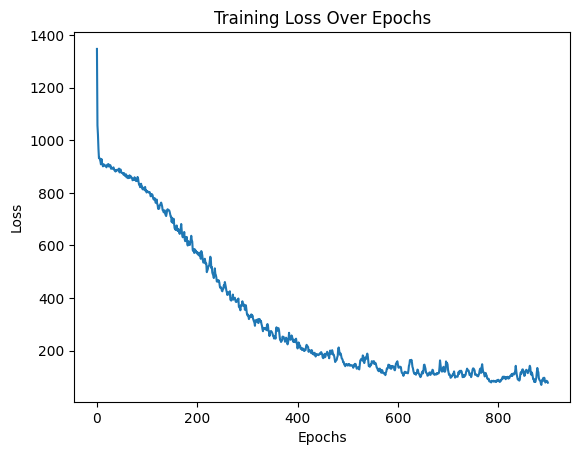

In [235]:
epoch = 50
count = 0
prev = float('inf')
model.train()
for iter in range(epoch):

    avg_loss = train(model, train_data_loader, optimizer, criterion)

    if iter%20 ==0 :
        if prev<avg_loss:
            count+=1
        # print(evaluate(model, train_data_loader) , avg_loss , iter )
        prev = avg_loss
    if iter%100==0:
        print(avg_loss , iter )
    loss_list.append(avg_loss)
    if count > 30:
        break
print(avg_loss)
plt.plot(loss_list)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()



In [213]:
# evaluate(model, train_data_loader)
torch.save(model.state_dict() ,"batting_1.pth")

In [240]:
model.load_state_dict(torch.load("batting_1.pth"))

<All keys matched successfully>

In [244]:
evaluate(model , DataLoader([data.get_batting_data("Chris Gale",'Wankhede Stadium, Mumbai',2023)  ]))

KeyError: 'Chris Gale'

In [243]:
evaluate(model, train_data_loader)


tensor([10.4129])